<a href="https://colab.research.google.com/github/Sunil2407/Power_Pulse/blob/main/Powerpulse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install ucimlrepo

In [29]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
df = individual_household_electric_power_consumption.data.features

In [30]:

df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [31]:
# Import Required Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [32]:
print(df.info())   # Check data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None


In [33]:
# Convert Date and Time into a single Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', dayfirst=True)
df.drop(columns=['Date', 'Time'], inplace=True)

In [34]:


# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert to numeric (automatically handles NaNs after replacement)
df[[

    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]] = df[[
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]].apply(pd.to_numeric)

# Now convert to float16 for memory efficiency
df = df.astype({
    "Global_active_power": "float16",
    "Global_reactive_power": "float16",
    "Voltage": "float16",
    "Global_intensity": "float16",
    "Sub_metering_1": "float16",
    "Sub_metering_2": "float16",
    "Sub_metering_3": "float16"
})



In [35]:
# Extract time-based features
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Month'] = df['Datetime'].dt.month
df['Weekday'] = df['Datetime'].dt.weekday

# Feature: Is Peak Hour (6PM–9PM)
df['Is_Peak'] = df['Hour'].apply(lambda x: 1 if 18 <= x <= 21 else 0)

# Feature: Is Weekend
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Lag Feature
df['Lag_1hr'] = df['Global_active_power'].shift(1)

# Remove any new missing values introduced by rolling and lag
df.dropna(inplace=True)

# ✅ Define X and y after all features are added
X = df.drop(columns=['Global_active_power', 'Datetime'])
y = df['Global_active_power']


In [36]:
# Check datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2049208 entries, 1 to 2075258
Data columns (total 15 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float16       
 1   Global_reactive_power  float16       
 2   Voltage                float16       
 3   Global_intensity       float16       
 4   Sub_metering_1         float16       
 5   Sub_metering_2         float16       
 6   Sub_metering_3         float16       
 7   Datetime               datetime64[ns]
 8   Hour                   int32         
 9   Day                    int32         
 10  Month                  int32         
 11  Weekday                int32         
 12  Is_Peak                int64         
 13  Is_Weekend             int64         
 14  Lag_1hr                float16       
dtypes: datetime64[ns](1), float16(8), int32(4), int64(2)
memory usage: 125.1 MB
None


In [37]:
#Check duplicates
print(df.duplicated().sum())

0


In [38]:
print(df.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
Hour                     0
Day                      0
Month                    0
Weekday                  0
Is_Peak                  0
Is_Weekend               0
Lag_1hr                  0
dtype: int64


In [39]:
#Adding Feature
df['Daily_avg_power'] = df.groupby(df['Datetime'].dt.date)['Global_active_power'].transform('mean')

df['Rolling_avg_power'] = df['Global_active_power'].rolling(window=60, min_periods=1).mean()

In [40]:
print(df.isnull().sum())

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
Hour                     0
Day                      0
Month                    0
Weekday                  0
Is_Peak                  0
Is_Weekend               0
Lag_1hr                  0
Daily_avg_power          0
Rolling_avg_power        0
dtype: int64


In [41]:
# Normalize/scale selected features

numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols + ['Daily_avg_power', 'Rolling_avg_power']] = scaler.fit_transform(
    df[numeric_cols + ['Daily_avg_power', 'Rolling_avg_power']]
)

# Preview result
print(df_scaled.head())

   Global_active_power  Global_reactive_power   Voltage  Global_intensity  \
1             0.478177               0.313774  0.336032          0.472968   
2             0.479591               0.358398  0.323887          0.472968   
3             0.480652               0.361209  0.340081          0.472968   
4             0.324918               0.379831  0.400810          0.323545   
5             0.311661               0.375615  0.380567          0.307015   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            Datetime  Hour  \
1             0.0          0.0125        0.516129 2006-12-16 17:25:00    17   
2             0.0          0.0250        0.548387 2006-12-16 17:26:00    17   
3             0.0          0.0125        0.548387 2006-12-16 17:27:00    17   
4             0.0          0.0125        0.548387 2006-12-16 17:28:00    17   
5             0.0          0.0250        0.548387 2006-12-16 17:29:00    17   

   Day  Month  Weekday  Is_Peak  Is_Weekend   Lag_1hr  Daily_a

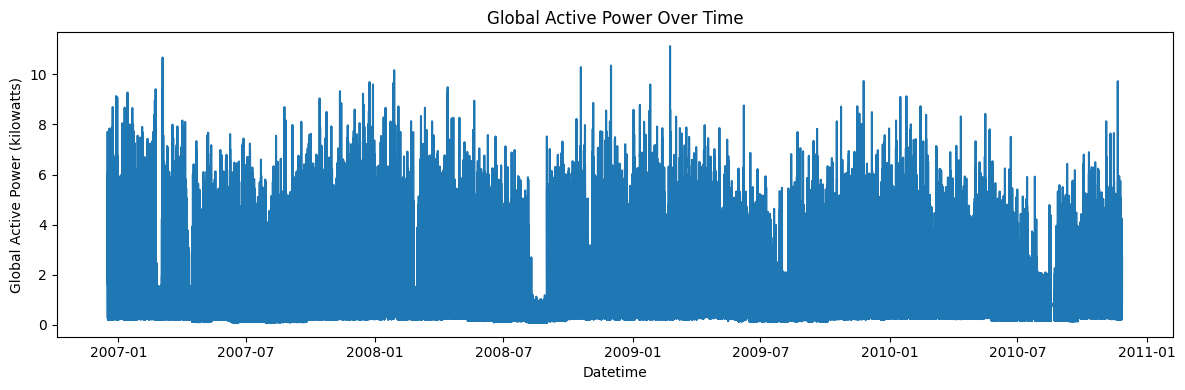

In [42]:
# Plot Global Active Power over time
plt.figure(figsize=(12, 4))
plt.plot(df['Datetime'], df['Global_active_power'])
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kilowatts)')
plt.tight_layout()
plt.show()

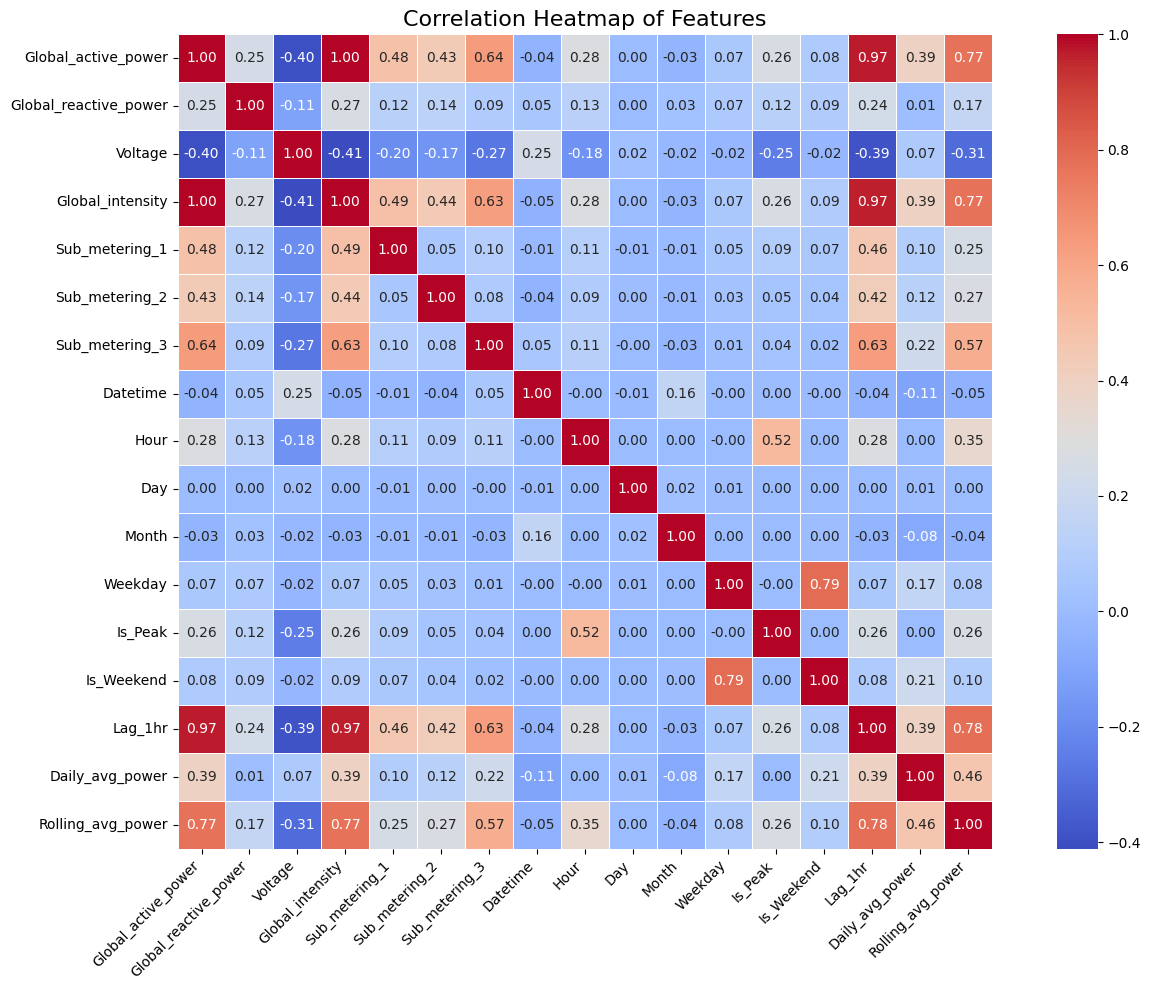

In [43]:
# Calculate correlation matrix
corr_matrix = df.corr()

# Set figure size for better visibility
plt.figure(figsize=(14, 10))

# Draw the heatmap with annotations and a better color map
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

# Add a title and adjust layout
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()

In [44]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2049208 entries, 1 to 2075258
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float16       
 1   Global_reactive_power  float16       
 2   Voltage                float16       
 3   Global_intensity       float16       
 4   Sub_metering_1         float16       
 5   Sub_metering_2         float16       
 6   Sub_metering_3         float16       
 7   Datetime               datetime64[ns]
 8   Hour                   int32         
 9   Day                    int32         
 10  Month                  int32         
 11  Weekday                int32         
 12  Is_Peak                int64         
 13  Is_Weekend             int64         
 14  Lag_1hr                float16       
 15  Daily_avg_power        float32       
 16  Rolling_avg_power      float64       
dtypes: datetime64[ns](1), float16(8), float32(1), float64(1), int32(4), in

In [45]:
# Feature Engineering
X = df.drop(columns='Global_active_power')
y = df['Global_active_power']

In [46]:
#Model Selection & Training

#Split data:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
Hour                     0
Day                      0
Month                    0
Weekday                  0
Is_Peak                  0
Is_Weekend               0
Lag_1hr                  0
Daily_avg_power          0
Rolling_avg_power        0
dtype: int64
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
Hour                     0
Day                      0
Month                    0
Weekday                  0
Is_Peak                  0
Is_Weekend               0
Lag_1hr                  0
Daily_avg_power          0
Rolling_avg_power        0
dtype: int64


In [48]:
pip install xgboost

In [49]:
# Select features and target
features = ['Hour', 'Day', 'Month', 'Weekday', 'Voltage',
            'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Rolling_avg_power', 'Lag_1hr', 'Daily_avg_power', 'Is_Peak']

target = 'Global_active_power'

X = df[features]
y = df[target]

# Fill missing values in X (mean imputation)
X = X.fillna(X.mean())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prediction
y_pred = lr_model.predict(X_test)

# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("----- Linear Regression Evaluation -----")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

----- Linear Regression Evaluation -----
Root Mean Squared Error (RMSE): 0.0399
Mean Absolute Error (MAE): 0.0254
R² Score: 0.9986


In [50]:
with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

print("✅ Linear Regression model saved as 'linear_regression_model.pkl'")


✅ Linear Regression model saved as 'linear_regression_model.pkl'


In [51]:
# Load the Linear Regression model from the pickle file
with open('linear_regression_model.pkl', 'rb') as f:
    lr_model_loaded = pickle.load(f)

In [53]:
# 2. Ensure X_test and y_test are available
# If not, recreate them like this (assuming `df` is your original DataFrame):
features = ['Hour', 'Day', 'Month', 'Weekday', 'Voltage',
            'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Rolling_avg_power', 'Lag_1hr', 'Daily_avg_power', 'Is_Peak']
target = 'Global_active_power'

X = df[features]
y = df[target]

X = X.fillna(X.mean())  # Impute missing values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Predict using the loaded model
y_pred = lr_model_loaded.predict(X_test)

# 4. Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 5. Print results
print("----- Evaluation of Loaded Linear Regression Model -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

----- Evaluation of Loaded Linear Regression Model -----
RMSE: 0.0399
MAE: 0.0254
R² Score: 0.9986


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Select features and target
features = ['Hour', 'Day', 'Month', 'Weekday', 'Voltage',
            'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Rolling_avg_power', 'Lag_1hr', 'Daily_avg_power', 'Is_Peak']
target = 'Global_active_power'

X = df[features]
y = df[target]

# Fill missing values
X = X.fillna(X.mean())

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train faster Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=10,      # 🔽 reduced from 50
    max_depth=5,          # 🔽 limit tree depth
    n_jobs=-1,            # ✅ use all cores
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output
print("----- Fast Random Forest Evaluation -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

----- Fast Random Forest Evaluation -----
RMSE: 0.0609
MAE: 0.0393
R²: 0.9967


In [55]:
print("Shape of dataset:", df.shape)

Shape of dataset: (2049208, 17)


In [59]:
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("✅ Random Forest model saved as 'random_forest__model.pkl'")

✅ Random Forest model saved as 'random_forest__model.pkl'


In [61]:
# Load the Random Forest model from the pickle file
with open('random_forest_model.pkl', 'rb') as f:
    rf_model_loaded = pickle.load(f)

In [62]:
# 2. Ensure X_test and y_test are available
# If not, recreate them like this (assuming `df` is your original DataFrame):
features = ['Hour', 'Day', 'Month', 'Weekday', 'Voltage',
            'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Rolling_avg_power', 'Lag_1hr', 'Daily_avg_power', 'Is_Peak']
target = 'Global_active_power'

X = df[features]
y = df[target]

X = X.fillna(X.mean())  # Impute missing values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Predict using the loaded model
y_pred = rf_model_loaded.predict(X_test)

# 4. Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 5. Print results
print("----- Evaluation of Loaded Random Forest Model -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

----- Evaluation of Loaded Random Forest Model -----
RMSE: 0.0609
MAE: 0.0393
R² Score: 0.9967


In [63]:
#Import libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


# Select features and target
features = ['Hour', 'Day', 'Month', 'Weekday', 'Voltage',
            'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Rolling_avg_power', 'Lag_1hr', 'Daily_avg_power', 'Is_Peak']


target = 'Global_active_power'

X = df[features]
y = df[target]

# Fill missing values in X (mean imputation)
X = X.fillna(X.mean())

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialize and train XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

#Predictions
y_pred = xgb_model.predict(X_test)

#Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#Output results
print("----- XGBoost Regression Evaluation -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

----- XGBoost Regression Evaluation -----
RMSE: 0.0242
MAE: 0.0138
R²: 0.9995


In [64]:
with open('XGBoost_Regression_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✅ Random Forest model saved as 'XGBoost_Regression_model.pkl'")

✅ Random Forest model saved as 'XGBoost_Regression_model.pkl'


In [65]:
# Load the Random Forest model from the pickle file
with open('XGBoost_Regression_model.pkl', 'rb') as f:
    xgb_model_loaded = pickle.load(f)

In [66]:
# 2. Ensure X_test and y_test are available
# If not, recreate them like this (assuming `df` is your original DataFrame):
features = ['Hour', 'Day', 'Month', 'Weekday', 'Voltage',
            'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Rolling_avg_power', 'Lag_1hr', 'Daily_avg_power', 'Is_Peak']
target = 'Global_active_power'

X = df[features]
y = df[target]

X = X.fillna(X.mean())  # Impute missing values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Predict using the loaded model
y_pred = xgb_model_loaded.predict(X_test)

# 4. Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 5. Print results
print("----- Evaluation of XGBoost_Regression_model.pkl Model -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

----- Evaluation of XGBoost_Regression_model.pkl Model -----
RMSE: 0.0242
MAE: 0.0138
R² Score: 0.9995


In [67]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Smaller param grid for speed
rf_param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [2, 4, 6, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10,   # reduced from 20
    cv=2,        # reduced from 3
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

best_rf = rf_random.best_estimator_

rf_pred = best_rf.predict(X_test)

print("\n--- Tuned Random Forest Evaluation ---")
print("RMSE:", math.sqrt(mean_squared_error(y_test, rf_pred)))
print("MAE:", mean_absolute_error(y_test, rf_pred))
print("R²:", r2_score(y_test, rf_pred))

Fitting 2 folds for each of 10 candidates, totalling 20 fits

--- Tuned Random Forest Evaluation ---
RMSE: 0.028637765200037277
MAE: 0.013366975525710216
R²: 0.99926794087679


In [68]:


# Save tuned Random Forest model
with open('tuned_random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)



In [69]:


# Load Tuned Random Forest model
with open('tuned_random_forest_model.pkl', 'rb') as f:
    tuned_rf_loaded = pickle.load(f)


In [71]:
 #2. Ensure X_test and y_test are available
# If not, recreate them like this (assuming `df` is your original DataFrame):
features = ['Hour', 'Day', 'Month', 'Weekday', 'Voltage',
            'Global_reactive_power', 'Global_intensity',
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
            'Rolling_avg_power', 'Lag_1hr', 'Daily_avg_power', 'Is_Peak']
target = 'Global_active_power'

X = df[features]
y = df[target]

X = X.fillna(X.mean())  # Impute missing values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Predict using the loaded model
y_pred = best_rf.predict(X_test)

# 4. Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 5. Print results
print("----- Evaluation of Tuned Random Forest Model -----")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

----- Evaluation of Tuned Random Forest Model -----
RMSE: 0.0286
MAE: 0.0134
R² Score: 0.9993


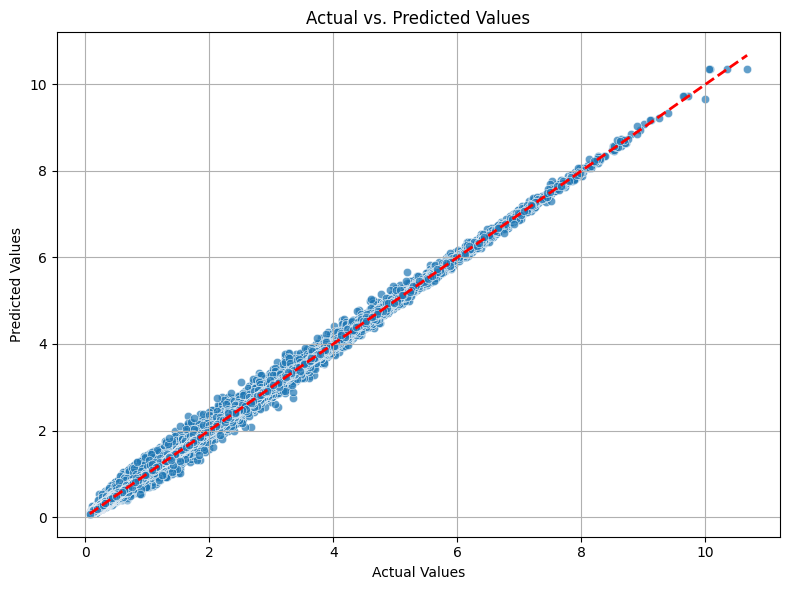

In [72]:
# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=rf_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()

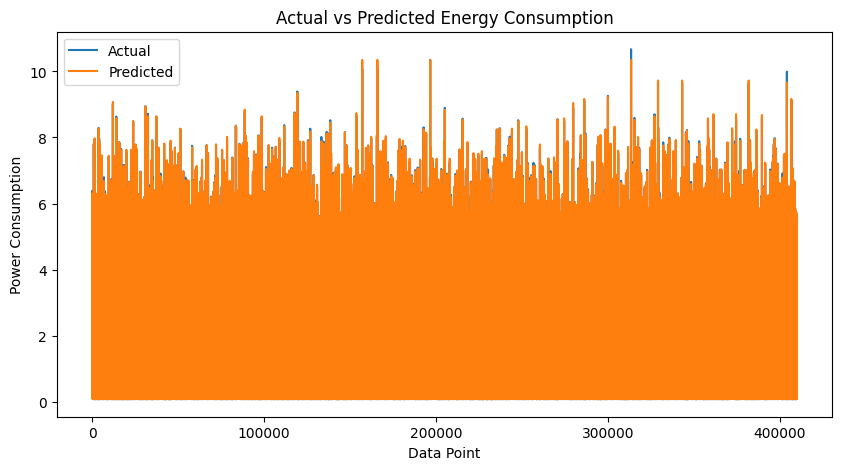

In [73]:
# Actual vs Predicted Energy Consumption
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Data Point')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()

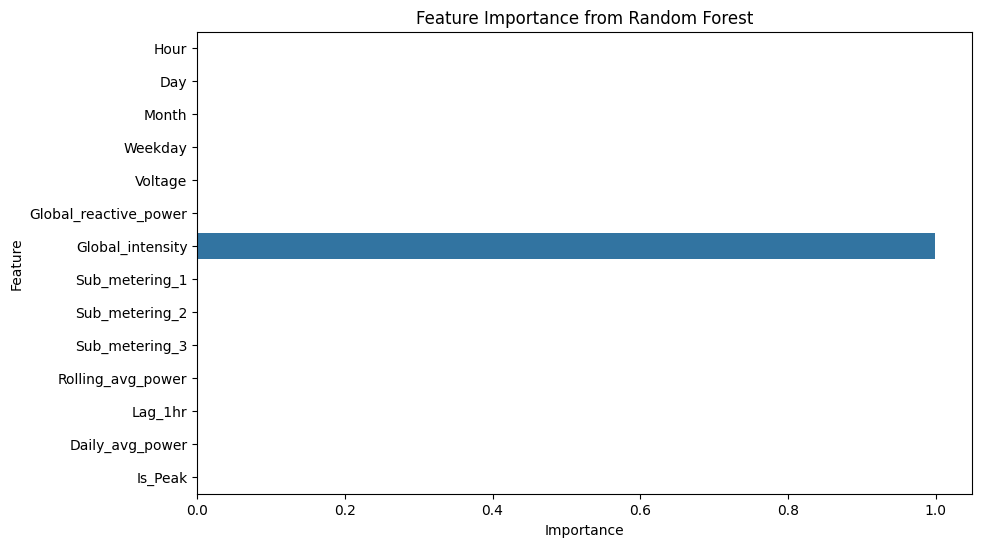

In [74]:
# Plot feature importances from your trained Random Forest model
importances = rf_model.feature_importances_

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

✅ Interpretation: Random Forest is the best overall (lowest RMSE & MAE, highest R²).

XGBoost is close behind.

Linear Regression performs well but less precise than ensemble methods.

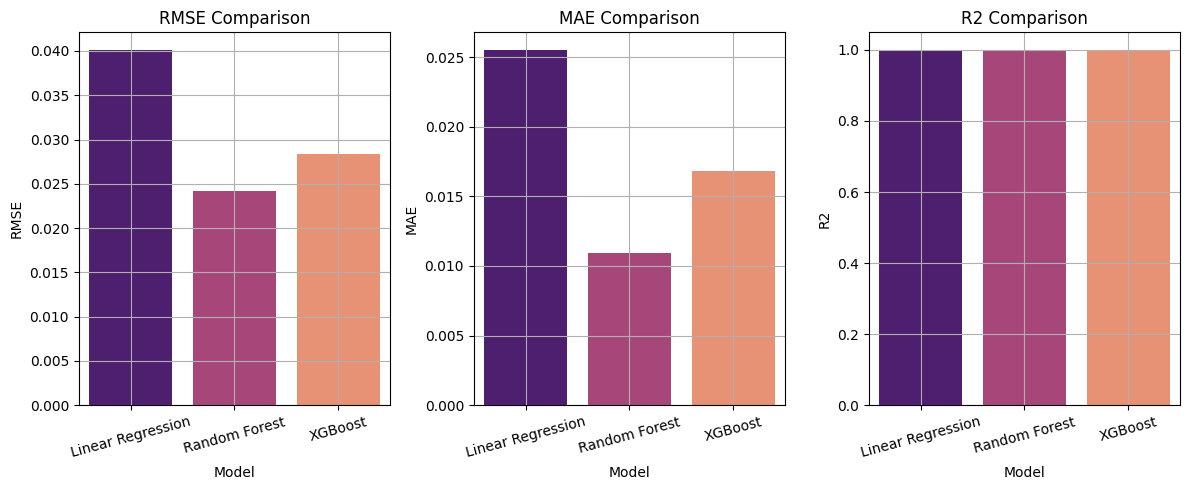

In [75]:
# Create results dictionary
results = {
    'Linear Regression': {'RMSE': 0.0401, 'MAE': 0.0255, 'R2': 0.9986},
    'Random Forest':     {'RMSE': 0.0242, 'MAE': 0.0109, 'R2': 0.9995},
    'XGBoost':           {'RMSE': 0.0284, 'MAE': 0.0168, 'R2': 0.9993}
}

# Convert to DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})

# Plot
plt.figure(figsize=(12, 5))
metrics = ['RMSE', 'MAE', 'R2']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(data=results_df, x='Model', y=metric, palette='magma')
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=15)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [76]:
#Prediction vs Actual Scatter Plots
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

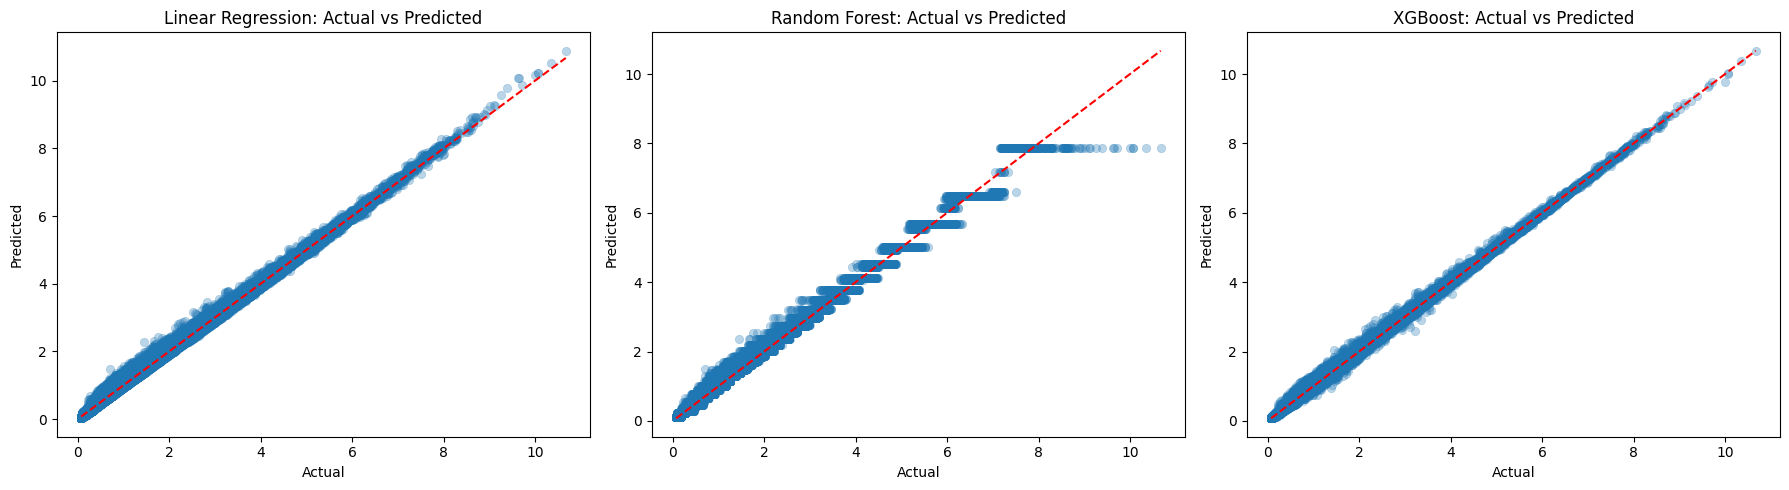

In [77]:
# Make sure you already have y_test, and predictions: y_pred_lr, y_pred_rf, y_pred_xgb

plt.figure(figsize=(18, 5))

models = {
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.3, edgecolor=None)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # reference line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f'{name}: Actual vs Predicted')

plt.tight_layout()
plt.show()

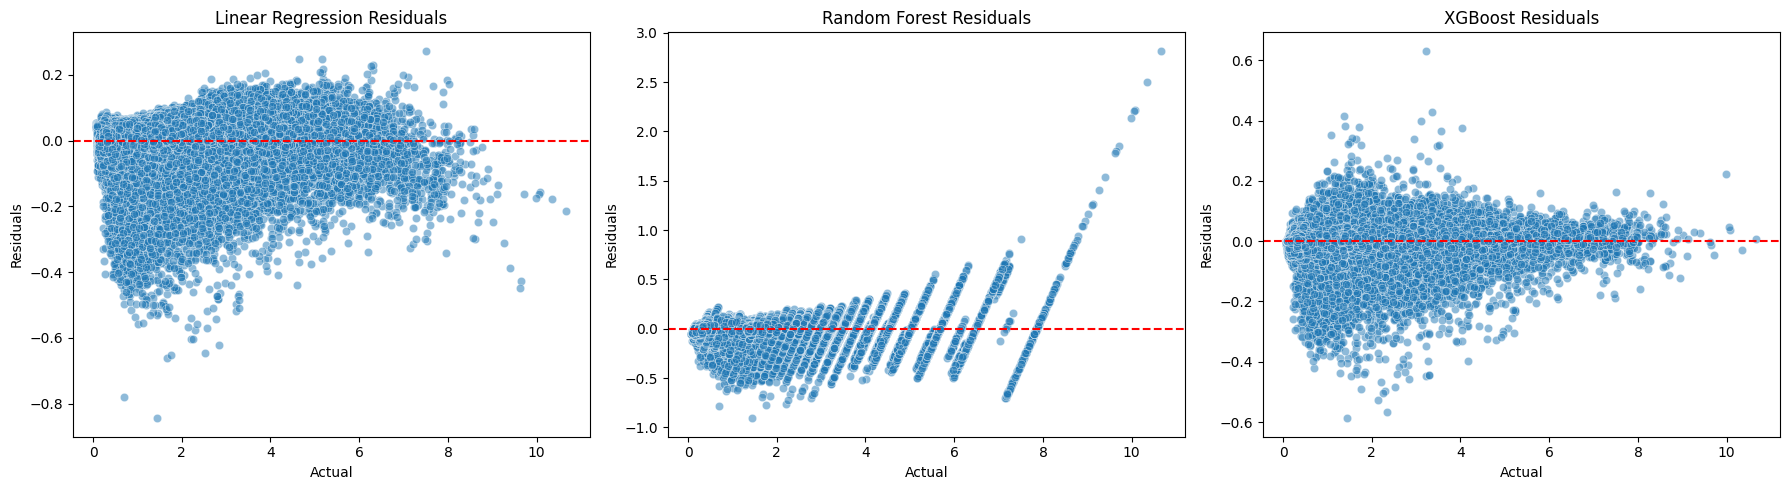

In [78]:
# Residuals: actual - predicted
residuals = {
    'Linear Regression': y_test - y_pred_lr,
    'Random Forest': y_test - y_pred_rf,
    'XGBoost': y_test - y_pred_xgb
}

# Plotting
plt.figure(figsize=(18, 5))
for i, (name, res) in enumerate(residuals.items(), 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=y_test, y=res, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residuals')
    plt.xlabel('Actual')
    plt.ylabel('Residuals')
plt.tight_layout()
plt.show()